In [57]:
import os
import numpy as np
from scipy import integrate
import mdtraj
import matplotlib.pyplot as plt
%matplotlib inline

## Objective
Calculate the self-diffusion coefficient of TIP3P water from a molecular dynamics simulation.  
The reference value is $5.19 \times 10^{-5} cm^2/s$. (See below for source.)  
**Final answer, calculated from average of all water molecules =** $-2.41 \times 10^{-5} cm^2/s$  
Yes, it shouldn't be negative. TODO: rerun simulation with snapshots every 1 fs instead of every 100 fs.

*&ast;&ast;   See additional notes in acf.ipynb   &ast;&ast;* 

In [58]:
def readXYZnamd(infile):
    """
    Read in a pre-processed XYZ file from NAMD. 
    
    This was obtained from the NAMD binary file using the catdcd utility:
      'catdcd -s waterbox.psf -stype psf -i solu.index -o vels_0.xyz -otype xyz usWat-1.veldcd'
      Here, usWat-1.veldcd is the name of the binary file, and 
      solu.index is a plain ASCII file with 0 1 2 each on a new line bc those are the indices
      of the OH2, H1, H2 atoms of my specific water molecule.
      See more: http://www.ks.uiuc.edu/Development/MDTools/catdcd/
    The file was processed to remove all lines that didn't have velocity data.
    
    Parameter
    ---------
    infile: string name of pre-processed XYZ file 
    
    Returns
    -------
    vel*: numpy arrays of the 1st, 2nd, and 3rd columns in the file
    """
    velx, vely, velz = np.loadtxt(infile, usecols=(1,2,3), dtype=float, unpack=True)

    # internal namd units  --[* 20.45482706] --> Angstroms/picosecond
    # Angstroms/picosecond --[* 100.0]       --> m/s
    print(velx[0])
    velx, vely, velz = 20.45482706*velx, 20.45482706*vely, 20.45482706*velz
    
    return velx, vely, velz

In [59]:
def calcCOM(inlist):
    """
    Calculate center of mass of the given timeseries.
       x_CM = (m1*x1 + m2*x2 + m3*x3) / (m1 + m2 + m3)

    Parameter
    ---------
    inlist: list of tuples, where each tuple is (weight, listData)
             ex., [(atomMass1, list1), (atomMass2, list2)]

    Returns
    -------
    final: list of center of mass of all the tuple list components

    """
    weighted = []
    denom = []
    for i in inlist:
        denom.append(i[0])
        weighted.append(i[0]*i[1])
    numerator = np.sum(weighted, axis=0)
    denominator = np.sum(denom)
    final = numerator / denominator
    return final

In [60]:
def calcACF(series, norm=False):
    """
    Calculate the autocorrelation function of the given timeseries.
    Modified code from David Wych.
       Cz(t) = 1/nSamples sum[ deltaZ(i) * deltaZ(i+t), {i=0, imax=nSamples} ]
       deltaZ(i) = z(i) - avgZ
    
    Parameters
    ----------
    series: numpy list of data from which to calculate the autocorrelation function
    norm: Boolean variable, whether to normalize output or not
    
    Returns
    -------
    C*: list containing the autocorrelation function
    
    
    """
    # assign cutoff from half of timeseries data
    N = len(series)
    cutoff = int(N/2)
    avg = np.average(series)
    
    # calculate ACF here
    lt = 0
    C_prime = []
    while lt <= cutoff:
        temp = []
        nSamples = N-lt
        for i in range(nSamples):
            temp.append((series[i]-avg)*(series[i+lt]-avg))
        term = np.sum(temp)/nSamples
        C_prime.append(term)
        lt += 1

    if not norm:
        return np.asarray(C_prime)

    # normalization: since working with dZs, use norm of dZ vector
    # I don't know if this is right...
    norms = []
    for i in range(N):
         norms.append((series[i]-avg)**2)
    normConst = np.sum(norms)/N # take average
    print(normConst)
    C = C_prime/normConst
    return C

In [61]:
# Load entire data
traj = mdtraj.load_dcd('run2/usWat-2.veldcd','waterbox.psf')

In [62]:
""" CODE FOR TESTING - 1
Playing around with mdtraj. """

# Get data as in traj.xyz[frameNum, atomNum, coord]
#   For frameNum, atomNum: 0 is the first atom
#   For coord: x = 0, y = 1, z = 2
#print(traj)
#traj.xyz[0,0:6,2]

# compute center-of-mass velocities; then convert units
#traj_com = mdtraj.compute_center_of_mass(traj) # shape (20000, 3)
#velx_all = traj_com[:,0]*10*20.4548270 # A/ps, shape (20000, 3)

' CODE FOR TESTING - 1\nPlaying around with mdtraj. '

In [63]:
# center of mass for mdtraj all atoms
# (1) calc center of mass by each water molecule
# (2) then average all molecules' resulting velocities
topology = traj.topology
o_indices = topology.select('name O')
h_indices = topology.select('name H1 or name H2')

# 10 mdtraj, 20.45 namd, 16 oxygen, 1.01 hydrogen
vels_all_O = np.asarray(traj.xyz[:,o_indices,:]*10*20.4548270*16.)   # shape is (nFrames, nMols, 3)
vels_all_H = np.asarray(traj.xyz[:,h_indices,:]*10*20.4548270*1.01)

# now combine mols together: sum and divide my molecular mass
nAtoms = 3
vels_all_sum = []
for i in range(vels_all_O.shape[1]):
    thissum = vels_all_O[:,i,:]+vels_all_H[:,(nAtoms-1)*i,:]+vels_all_H[:,(nAtoms-1)*(i)+1,:]
    vels_all_sum.append(thissum)
vels_all_sum = np.asarray(vels_all_sum)
vels_all_com = vels_all_sum/18.02         # shape is (nMols, nFrames, 3) !!

In [64]:
""" CODE FOR TESTING - 2
This was comparing the XYZ input for one mol to the same mol imported via mdtraj. 
Took out the xyz route, so for debugging, add code to read in XYZ and apply calcCOM. 
See acf.ipynb. """

# print("x of last water at frame 1 (no units, no weights):",traj.xyz[0,3000,0],traj.xyz[0,3001,0],traj.xyz[0,3002,0])
# print("x of last water at frame 1 (w/units, w/weights):",velx_all_O[0,-1],velx_all_H[0,-1],velx_all_H[0,-2])
# print("x of last water at frame 1 (w/units, no weights):",velx_0[0], velx_1[0], velx_2[0])
# print("x of last water at frame 1 (w/units, w/centerMass):",velx_com[0])
# print("x of last water at frame 1 (w/units, w/centerMass):",velx_all_com[-1,0])

# print("y of last water at frame 1 (w/units, w/centerMass):",vely_com[0])
# print("y of last water at frame 1 (w/units, w/centerMass):",vels_all_com[-1,0,1])

# print("z of last water at frame 1 (w/units, w/centerMass):",velz_com[0])
# print("z of last water at frame 1 (w/units, w/centerMass):",vels_all_com[-1,0,2])

' CODE FOR TESTING - 2\nThis was comparing the XYZ input for one mol to the same mol imported via mdtraj. \nTook out the xyz route, so for debugging, add code to read in XYZ and apply calcCOM. \nSee acf.ipynb. '

Text(0,0.5,'$\\AA$/ps')

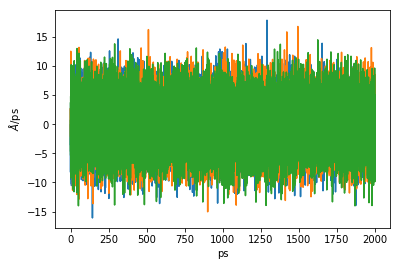

In [65]:
# Visualize velocity data
molindex = -1
plt.plot(np.arange(len(vels_all_com[-1,:,0]))/10,vels_all_com[-1,:,0])
plt.plot(np.arange(len(vels_all_com[-1,:,1]))/10,vels_all_com[-1,:,1])
plt.plot(np.arange(len(vels_all_com[-1,:,2]))/10,vels_all_com[-1,:,2])
plt.xlabel('ps')
plt.ylabel('$\AA$/ps')  # if dividing x-values by 10, use A/ps
#plt.ylabel('m/s')

In [66]:
""" CODE FOR TESTING - 3
This looked at averaging velocity data before calculating ACF.
This gets wildly skewed results. Take a look at the scale of the plot. """

# # now average over all molecules
# vels_all_avg = np.mean(vels_all_com, axis=0) # shape (nFrames, 3)

# # Visualize average of all velocity data
# plt.plot(np.arange(len(velx_all_avg))/10,velx_all_avg)
# plt.xlabel('ps')
# plt.ylabel('$\AA$/ps')  # if dividing x-values by 10, use A/ps
# #plt.ylabel('m/s')

' CODE FOR TESTING - 3\nThis looked at averaging velocity data before calculating ACF.\nThis gets wildly skewed results. Take a look at the scale of the plot. '

In [67]:
""" CODE FOR TESTING - 3 (continued) """

# # ACF on average velocity
# acf_all_x = calcACF(velx_all_avg, norm=False)
# print(integrate(acf_all_x, dx=0.1))
# plt.plot(np.arange(len(acf_all_x[:200]))/10,acf_all_x[:200], label='x')

' CODE FOR TESTING - 3 (continued) '

In [68]:
# calc ACF individually by mol then average at end -- TODO improve efficiency?
acf_list_x = []
acf_list_y = []
acf_list_z = []
diff_list_x = []
diff_list_y = []
diff_list_z = []
#for i in range(nMols):
for i in range(10):
    #if i%10==0: 
    print(i) # status check
    acf_i_x = calcACF(vels_all_com[i,:,0], norm=False)
    acf_i_y = calcACF(vels_all_com[i,:,1], norm=False)
    acf_i_z = calcACF(vels_all_com[i,:,2], norm=False)
    acf_list_x.append(acf_i_x)
    acf_list_y.append(acf_i_y)
    acf_list_z.append(acf_i_z)
    diff_list_x.append(integrate.simps(acf_i_x, dx=0.1))
    diff_list_y.append(integrate.simps(acf_i_y, dx=0.1))
    diff_list_z.append(integrate.simps(acf_i_z, dx=0.1))

0
1
2
3
4
5
6
7
8
9


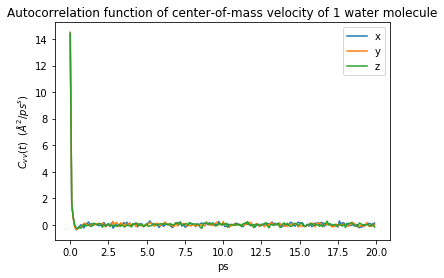

In [69]:
trim = 200
plt.plot(np.arange(len(acf_list_x[1][:trim]))/10,acf_list_x[1][:trim], label='x')
plt.plot(np.arange(len(acf_list_y[1][:trim]))/10,acf_list_y[1][:trim], label='y')
plt.plot(np.arange(len(acf_list_z[1][:trim]))/10,acf_list_z[1][:trim], label='z')
plt.xlabel('ps')
plt.ylabel('$C_{vv}(t) \ \ (\AA^2/ps^s)$')
plt.title("Autocorrelation function of center-of-mass velocity of 1 water molecule")
plt.legend()

In [70]:
acf_avg_x = np.mean(np.asarray(acf_list_x), axis=0)
acf_avg_y = np.mean(np.asarray(acf_list_y), axis=0)
acf_avg_z = np.mean(np.asarray(acf_list_z), axis=0)
diff_avg_x, diff_avg_y, diff_avg_z = integrate.simps(acf_avg_x, dx=0.1), integrate.simps(acf_avg_y, dx=0.1), integrate.simps(acf_avg_z, dx=0.1)
print(diff_avg_x, diff_avg_y, diff_avg_z)
diff_avg_scaled = sum([diff_avg_x, diff_avg_y, diff_avg_z])/3*1e-8 # m2/s: (1e-20) A2 to m2, (1e12) 1/ps to 1/s
diff_avg_scaled

-0.0780135625758 -0.0702227784189 -0.575040330738


-2.4109222391094328e-09

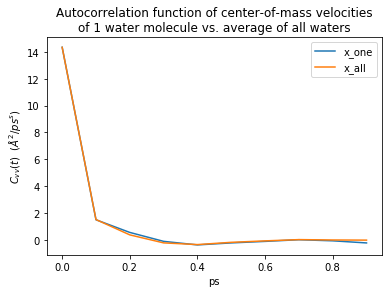

In [75]:
trim = 10
plt.plot(np.arange(len(acf_list_x[1][:trim]))/10,acf_list_x[1][:trim], label='x_one')
plt.plot(np.arange(len(acf_avg_x[:trim]))/10,acf_avg_x[:trim], label='x_all')
plt.xlabel('ps')
plt.ylabel('$C_{vv}(t) \ \ (\AA^2/ps^s)$')
plt.title("Autocorrelation function of center-of-mass velocities\nof 1 water molecule vs. average of all waters")
plt.legend()

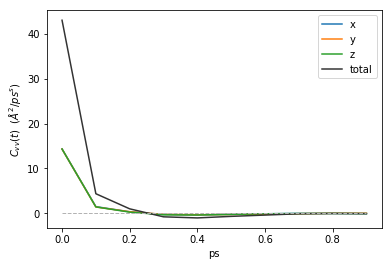

In [78]:
acf_sum = acf_avg_x + acf_avg_y + acf_avg_z

# visualize the ACF
trim = 10
plt.plot(np.arange(len(acf_avg_x[:trim]))/10,acf_avg_x[:trim], label='x')
plt.plot(np.arange(len(acf_avg_y[:trim]))/10,acf_avg_y[:trim], label='y')
plt.plot(np.arange(len(acf_avg_z[:trim]))/10,acf_avg_z[:trim], label='z')
plt.plot(np.arange(len(acf_sum[:trim]))/10,acf_sum[:trim], label='total', c='0.2')
plt.plot(np.arange(len(acf_avg_z[:trim]))/10,np.zeros(len(acf_avg_z[:trim])), c='0.7',lw=1.0,ls='--')
plt.xlabel('ps')
plt.ylabel('$C_{vv}(t) \ \ (\AA^2/ps^s)$')
plt.legend()